# Pembuatan Sistem Rekomendasi untuk Film/Movie berdasarkan Metode Content-based dan Collaborative Filtering

## Problem Statements

Bagian ini menguraikan pertanyaan-pertanyaan kunci yang akan dijawab oleh proyek ini. Dengan berfokus pada implementasi content-based filtering dan collaborative filtering, pernyataan masalah ini akan memandu eksplorasi dan pengembangan sistem rekomendasi film.

1. Bagaimana sistem rekomendasi film berbasis content-based filtering dapat diimplementasikan untuk secara efektif merekomendasikan film kepada pengguna berdasarkan preferensi mereka terhadap atribut film (genre)?

2. Bagaimana sistem rekomendasi film berbasis collaborative filtering dapat diimplementasikan untuk secara akurat memprediksi preferensi pengguna dan merekomendasikan film berdasarkan pola perilaku pengguna lain yang serupa?

## Data Understanding

Sumber Movie and Rating dataset:

https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system/data

In [81]:
import pandas as pd

movie = pd.read_csv('data/movies/movies.csv')
rating = pd.read_csv('data/movies/ratings.csv')

print('Jumlah data movie: ', len(movie.movieId.unique()))
print('Jumlah data rating: ', len(rating.userId.unique()))


Jumlah data movie:  62423
Jumlah data rating:  162541


### Cek Info dan Kelengkapan Dataset

In [91]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


1. Dataset `movies.csv`:

- `movieId`: Merupakan ID unik untuk setiap film.
- `title`: Merupakan judul film, yang juga menyertakan tahun rilis film tersebut.
- `genres`: Merupakan kategori genre dari film, yang dapat berupa beberapa genre yang dipisahkan oleh karakter pip '`|`'. Contoh: "`Adventure|Animation|Children|Comedy|Fantasy`". Dalam pra-pemrosesan, nilai ini diubah menjadi huruf kecil dan spasi dihilangkan (misalnya "`adventure animation children comedy fantasy`").

In [92]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


2. Dataset `ratings.csv`:

- `userId`: Merupakan ID unik untuk setiap pengguna yang memberikan rating.
- `movieId`: Merupakan ID film yang di-rating oleh pengguna.
- `rating`: Merupakan nilai rating yang diberikan pengguna kepada film, dalam skala 0.5 hingga 5.0. Distribusi rating menunjukkan bahwa rating 4.0 adalah yang paling sering diberikan, diikuti oleh 3.0 dan 5.0.
- `timestamp`: Merupakan waktu saat rating diberikan (dalam format Unix timestamp). Kolom ini dihilangkan dari analisis karena memang tidak dibutuhkan dalam proses pembentukan sistem rekomendasi pada proyek ini.

In [5]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [90]:
rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [93]:
movie.describe()

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [94]:
rating.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


Berdasarkan kedua tabel diatas, dapat dilihat bahwasannya hasilnya bagus tidak ada nilai missing yang tersembunyi seperti yang dikhawatirkan.

### Mengecek Outlier

<Axes: xlabel='rating'>

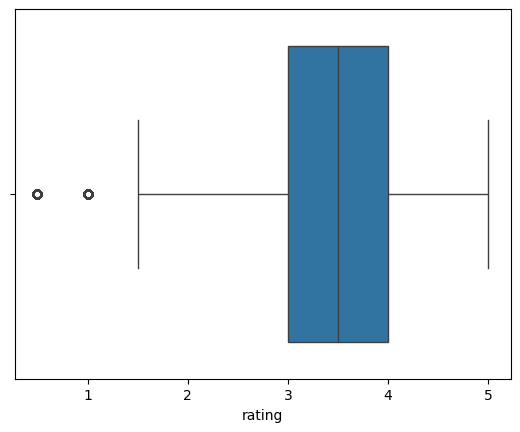

In [86]:
import seaborn as sns

sns.boxplot(x='rating', data=rating)

Jika kita melihat pada visualisasi, terdapat 2 titik yang dapat diamati berada kurang dari Q1, namun jika dilihat dari permasalahan yang ingin kita selesaikan yaitu sistem rekomendasi, dimana pengguna bisa saja memang memberikan rating yang rendah, maka hal ini dianggap wajar dan pada proyek ini tidak akan dianggap sebagai sebuah outlier.

### Univariate Analysis

Masih mengikuti cara pada pembahasan sebelumnya, diketahui bahwa data yang bisa diobservasi adalah data rating, kali ini akan dilakukan plot histogram untuk mengetahui distribusi dari rating 0-5:

<Axes: xlabel='rating', ylabel='Count'>

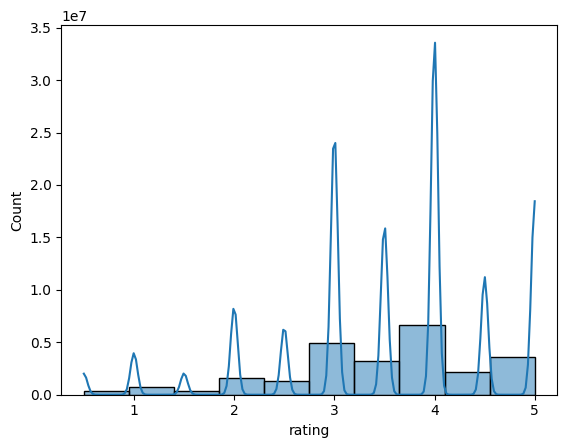

In [89]:
sns.histplot(rating['rating'], bins=10, kde=True)

Dari gambar diatas dapat diobservasi bahwasannya data memiliki konsentrasi pada rating 4, menunjukkan histogram yang <i>left-skewed</i>

## Content-Based Filtering

### Data Preparation

#### Movie Dataset Preprocessing

Kolom `genres` pada `DataFrame` `movie` diubah dengan menghapus karakter spasi `(' ')` dan mengubah semua teks menjadi huruf kecil `(.str.lower())`.
- Alasan: Standardisasi format `genre` ini penting untuk memastikan konsistensi. Menghilangkan spasi dan mengubah ke huruf kecil menghindari duplikasi `genre` yang sebenarnya sama (misalnya, "Action" dan "action") dan memastikan bahwa TF-IDF Vectorizer dapat memprosesnya dengan benar sebagai entitas tunggal, sehingga perhitungan kesamaan menjadi lebih akurat.

In [6]:
movie['genres'] = movie['genres'].str.replace('|',' ',regex=False).str.lower()

### Pemodelan

#### Pembentukan Representasi Film

Fitur genres dari setiap film diolah menggunakan `TfidfVectorizer()` untuk menghasilkan representasi numerik. Matriks TF-IDF yang dihasilkan memiliki dimensi 62423 film dengan 24 genre unik. Setiap baris dalam matriks ini mewakili sebuah film, dan nilai di setiap kolom menunjukkan relevansi genre tertentu bagi film tersebut.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()

tf.fit(movie['genres'])

tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

In [11]:
tfidf_matrix = tf.transform(movie['genres'])

tfidf_matrix.shape

(62423, 24)

In [12]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=movie['title']
).sample(10, axis=1).sample(10, axis=0)

,thriller,horror,mystery,imax,noir,musical,no,sci,fi,documentary
title,,,,,,,,,,
City of God (Cidade de Deus) (2002),0.429282,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U Me Aur Hum (2008),0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Don't Torture a Duckling (Non si sevizia un paperino) (1972),0.492405,0.553305,0.671856,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Amityville Horror, The (2005)",0.664800,0.747022,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
How to Stop Being a Loser (2011),0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Winter of Frozen Dreams (2009),0.651798,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Masquerade (1988),0.503793,0.000000,0.687394,0.0,0.0,0.0,0.0,0.0,0.0,0.0
An Afternoon (2014),0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5 to 7 (2014),0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Perhitungan Kesamaan

**Perhitungan Kesamaan**: Setelah representasi TF-IDF terbentuk, cosine_similarity dihitung antara semua film. Ini menghasilkan matriks kesamaan (cosine similarity matrix) dengan dimensi 62423x62423, di mana setiap sel menunjukkan tingkat kemiripan genre antara dua film.

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.82728864, 0.16620386, ..., 0.21483032, 0.        ,
        0.31776868],
       [0.82728864, 1.        , 0.        , ..., 0.        , 0.        ,
        0.38410859],
       [0.16620386, 0.        , 1.        , ..., 0.46294686, 0.        ,
        0.        ],
       ...,
       [0.21483032, 0.        , 0.46294686, ..., 1.        , 0.        ,
        0.2297483 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.31776868, 0.38410859, 0.        , ..., 0.2297483 , 0.        ,
        1.        ]])

In [14]:
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    columns=movie['title'],
    index=movie['title']
)

print('Shape: ', cosine_sim_df.shape)
# melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape:  (62423, 62423)


title,The Irrefutable Truth About Demons (2000),Who Is Cletis Tout? (2001),Wall Street (1987),Shotgun Stories (2007),Başka Semtin Çocukları (2008)
title,,,,,
Spotswood (1992),0.0,1.0,0.000000,0.000000,0.000000
"Colder Kind of Death, A (2001)",0.0,0.0,0.334033,0.179158,0.334033
Scooby-Doo! and the Gourmet Ghost (2018),0.0,0.0,0.000000,0.000000,0.000000
Pan (2015),0.0,0.0,0.000000,0.000000,0.000000
Hagbard and Signe (1967),0.0,0.0,1.000000,0.536348,1.000000
Icebreaker (2000),0.0,0.0,0.000000,0.440636,0.000000
La Bande du drugstore (2002),0.0,0.0,0.521986,0.279966,0.521986
The Siege of Firebase Gloria (1989),0.0,0.0,0.325614,0.174642,0.325614
"Red Shoes, The (1948)",0.0,0.0,0.252744,0.135558,0.252744


#### Mekanisme Rekomendasi (Top-N Recommendation)

Fungsi `movie_recommendations` dibuat untuk memberikan rekomendasi. Fungsi ini mengambil judul film (`title`), matriks kesamaan (`similarity_data`), `DataFrame` item (`items`), dan jumlah rekomendasi yang diinginkan (`k`, default 10) sebagai parameter. Fungsi ini mencari film dengan kesamaan terbesar pada indeks matriks kesamaan. Hasilnya adalah Top-N rekomendasi film yang memiliki genre paling mirip dengan film yang dipilih.

In [15]:
def movie_recommendations(title, similarity_data=cosine_sim_df, items=movie[['title','genres']], k=10):
    """
    Rekomendasi resto berdasarkan kemiripan dataframe

    Parameter:
    nama_resto : tipe data string (str)
                Nama Restoran (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan resto sebagai 
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---

    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i)

    """

    # mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # df diubah menjadi numpy
    # range (start, stop, step)

    index = similarity_data.loc[:, title].to_numpy().argpartition(
        range(-1, -k, -1)
    )

    # mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # drop name_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)


#### Output (Top-10 Recommendation)

In [58]:
movie_name = 'Yolanda and the Thief (1945)'

print(movie_name, ':',movie[movie.title.eq(
    movie_name
)].genres.values[0])

movie_recommendations(movie_name)

Yolanda and the Thief (1945) : fantasy musical romance


,title,genres
0,Xanadu (1980),fantasy musical romance
1,Brigadoon (1954),fantasy musical romance
2,Paheli (2005),drama fantasy musical romance
3,"Red Shoes, The (1948)",drama fantasy musical romance
4,Cenerentola '80 (1984),drama fantasy musical romance
5,Across the Universe (2007),drama fantasy musical romance
6,That Lady in Ermine (1948),comedy fantasy musical romance
7,"Magic Flute, The (Trollflöjten) (1975)",comedy fantasy musical romance
8,Princess Raccoon (Operetta tanuki goten) (2005),comedy fantasy musical romance
9,Aladin (2009),comedy fantasy musical romance


#### Evaluasi Output

Berdasarkan contoh rekomendasi yang dihasilkan untuk film `'Yolanda and the Thief (1945)' (genre: 'fantasy musical romance')`, sistem merekomendasikan film-film lain yang secara konsisten memiliki genre yang sama atau sangat mirip. Ini menunjukkan bahwa:

- Konsistensi Genre: Rekomendasi yang dihasilkan sangat relevan dari segi genre. Misalnya, film-film seperti "Xanadu (1980)", "Brigadoon (1954)", dan "Paheli (2005)" semuanya mengandung elemen fantasy, musical, atau romance.
- Kemampuan Menemukan Item Serupa: Model ini berhasil mengidentifikasi dan merekomendasikan film-film yang memiliki karakteristik konten serupa dengan film yang menjadi input, yang merupakan tujuan utama dari content-based filtering.

Meskipun evaluasi ini lebih kualitatif, konsistensi output berdasarkan genre mengindikasikan bahwa content-based filtering berhasil diimplementasikan untuk menyediakan rekomendasi yang relevan secara kontekstual. Untuk evaluasi yang lebih formal, pengujian A/B atau survei pengguna akan diperlukan untuk mengukur kepuasan dan tingkat relevansi secara lebih objektif.

## Colaborative Filtering

### Data Preparation

#### Rating Dataset Preprocessing

In [23]:
rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [24]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [25]:
rating.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [27]:
rating.drop(columns=['timestamp'], inplace=True)

Kolom `timestamp` pada DataFrame rating dihilangkan (dropped) karena tidak relevan untuk perhitungan rating atau rekomendasi dalam konteks model collaborative filtering yang akan dibangun.
- Alasan: Kolom `timestamp` tidak memberikan informasi langsung tentang preferensi pengguna terhadap film yang diperlukan untuk model collaborative filtering berbasis rating. Menghilangkannya mengurangi kompleksitas data dan kebutuhan memori.

In [28]:
rating.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [31]:
rating_clean = rating

#### Encoding `userId` dan `movieId`

Daftar `ID` pengguna unik (`user_ids`) dan `ID` film unik (`movie_ids`) dibuat dari `DataFrame` `rating_clean`. Kemudian dua mapping (kamus) dibuat: `user_to_user_encoded` (memetakan `userId` asli ke indeks numerik berurutan) dan `user_encoded_to_user` (memetakan kembali indeks numerik ke `userId` asli). Proses serupa dilakukan untuk `movieId` (`movie_to_movie_encoded` dan `movie_encoded_to_movie`). Kolom baru user dan movie ditambahkan ke `rating_clean` yang berisi `ID` yang sudah di-encode.
- Alasan: Model neural network memerlukan input numerik yang berurutan. Proses encoding ini mengubah `ID` pengguna dan film yang mungkin tidak berurutan atau terlalu besar menjadi indeks integer yang lebih kecil dan berurutan, yang efisien untuk digunakan sebagai input embedding layer dalam model neural network. Ini juga membantu dalam mengelola jumlah unique user dan movie secara terstruktur.

In [32]:
# mengubah userID menjadi list tanpa nilai yang sama
user_ids = rating_clean['userId'].unique().tolist()

# encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}

# proses encoding angka ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [33]:
len(user_ids)

162541

In [34]:
# ubag anime_id menjadi list unique
movie_ids = rating_clean['movieId'].unique().tolist()

# proses encoding anime_id
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# proses encoding angka ke anime_id
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

In [35]:
rating_clean['user'] = rating_clean['userId'].map(user_to_user_encoded)
rating_clean['movie'] = rating_clean['movieId'].map(movie_to_movie_encoded)

In [37]:
rating_clean.head()

,userId,movieId,rating,user,movie
0,1,296,5.0,0,0
1,1,306,3.5,0,1
2,1,307,5.0,0,2
3,1,665,5.0,0,3
4,1,899,3.5,0,4


#### Normalisasi Rating

Kolom rating di `DataFrame` `rating_clean` diubah tipe datanya menjadi `float32`. Kemudian, nilai rating dinormalisasi ke rentang antara 0 dan 1 menggunakan rumus: `(x−min_rating)/(max_rating−min_rating)`. Nilai `min_rating` adalah 0.5 dan `max_rating` adalah 5.0.

- Alasan: Normalisasi rating ke skala 0-1 adalah praktik umum dalam model neural network, terutama ketika menggunakan fungsi aktivasi sigmoid pada output layer yang menghasilkan nilai antara 0 dan 1. Ini membantu model belajar lebih stabil dan efisien, serta memastikan bahwa loss function (seperti Binary Crossentropy yang digunakan) bekerja dengan baik pada skala output yang sesuai.

In [38]:
import numpy as np

# jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# jumlah anime
num_movie = len(movie_to_movie_encoded)
print(num_movie)

# ubah rating -> float
rating_clean['rating'] = rating_clean['rating'].values.astype(np.float32)

# min rating
min_rating = min(rating_clean['rating'])

# max rating
max_rating = max(rating_clean['rating'])

print(f'Number of user: {num_users}\nNumber of Movie: {num_movie}\nMin Rating: {min_rating}\nMax Rating: {max_rating}',)

162541
59047
Number of user: 162541
Number of Movie: 59047
Min Rating: 0.5
Max Rating: 5.0


#### Train-Test-Split

Data `rating_clean` diacak (shuffled) secara acak dengan `random_state=42` untuk memastikan distribusi data yang merata. Kemudian, data dibagi menjadi set pelatihan (80%) dan set validasi (20%). Variabel `x` berisi pasangan (`user, movie`), dan `y` berisi rating yang dinormalisasi.

- Alasan: Pembagian data menjadi set pelatihan dan validasi sangat penting untuk mengevaluasi performa model secara objektif. Data pelatihan digunakan untuk mengajarkan model, sementara data validasi digunakan untuk menguji seberapa baik model dapat menggeneralisasi pada data yang belum pernah dilihat sebelumnya, membantu mendeteksi overfitting. Pengacakan data memastikan bahwa pembagian tersebut representatif.

In [39]:
rating_clean = rating_clean.sample(frac=1, random_state=42)
rating_clean

,userId,movieId,rating,user,movie
15347762,99476,104374,3.5,99475,3024
16647840,107979,2634,4.0,107978,9645
23915192,155372,1614,3.0,155371,1092
10052313,65225,7153,4.0,65224,227
12214125,79161,500,5.0,79160,964
...,...,...,...,...,...
13315092,86163,1610,3.0,86162,130
21081788,137027,112552,5.0,137026,772
23327850,151445,4019,5.0,151444,188
16094478,104327,3773,3.0,104326,8791


In [40]:
x = rating_clean[['user', 'movie']].values

y = rating_clean['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values

# bagi jadi 80:20
train_indices = int(0.8*rating_clean.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x,y)

[[ 99475   3024]
 [107978   9645]
 [155371   1092]
 ...
 [151444    188]
 [104326   8791]
 [150644    565]] [0.66666667 0.77777778 0.55555556 ... 1.         0.55555556 0.77777778]


### Pemodelan

In [41]:
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

#### Algoritma/Pendekatan
Pendekatan ini menggunakan arsitektur Neural Network (`RecommenderNet`) berbasis embedding untuk memprediksi rating film dan merekomendasikannya.

#### Arsitektur Model (`RecommenderNet`): 
Model dibangun menggunakan `TensorFlow Keras`.
- User dan Movie Embedding: Model memiliki lapisan embedding untuk `num_users` dan num_movie, masing-masing dengan ukuran `embedding_size` 10. Embedding ini diinisialisasi dengan '`he_normal`' dan diregularisasi dengan `L2`.
- User dan Movie Bias: Terdapat juga lapisan bias terpisah untuk pengguna dan film.
- Logika Prediksi: Fungsi call model menghitung perkalian titik (dot product) antara vektor embedding pengguna dan film, lalu menambahkan bias pengguna dan film. Hasilnya dilewatkan melalui fungsi aktivasi sigmoid untuk menghasilkan prediksi rating antara 0 dan 1.

In [42]:
class RecommenderNet(tf.keras.Model):

    # init func
    def __init__(self, num_users, num_movie, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movie = num_movie
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users,1)
        self.movie_embedding = layers.Embedding(
            num_movie,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movie,1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_resto = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_resto + user_bias + movie_bias
        return tf.nn.sigmoid(x)

#### Pelatihan Model
Model dikompilasi dengan `BinaryCrossentropy` sebagai loss function, `Adam` optimizer dengan `*learning_rate=0.0001`, dan `RootMeanSquaredError` sebagai metrik evaluasi
. Model dilatih selama 50 *epochs* dengan `batch_size=2048`. Proses pelatihan menunjukkan penurunan nilai `loss` dan `root_mean_squared_error` baik pada data train maupun test, menunjukkan model belajar dengan baik.

In [73]:
model = RecommenderNet(num_users, num_movie, 10) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    x_train,
    y_train,
    batch_size=2048,
    epochs=50,
    validation_data=(x_val, y_val),
)

Epoch 1/50
9766/9766 ━━━━━━━━━━━━━━━━━━━━ 115s 12ms/step - loss: 0.6388 - root_mean_squared_error: 0.2435 - val_loss: 0.6100 - val_root_mean_squared_error: 0.2152
Epoch 2/50
9766/9766 ━━━━━━━━━━━━━━━━━━━━ 109s 11ms/step - loss: 0.6078 - root_mean_squared_error: 0.2127 - val_loss: 0.6026 - val_root_mean_squared_error: 0.2073
Epoch 3/50
9766/9766 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - loss: 0.6014 - root_mean_squared_error: 0.2059 - val_loss: 0.5986 - val_root_mean_squared_error: 0.2030
Epoch 4/50
9766/9766 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - loss: 0.5977 - root_mean_squared_error: 0.2019 - val_loss: 0.5960 - val_root_mean_squared_error: 0.2002
Epoch 5/50
9766/9766 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 0.5951 - root_mean_squared_error: 0.1992 - val_loss: 0.5941 - val_root_mean_squared_error: 0.1982
Epoch 6/50
9766/9766 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - loss: 0.5934 - root_mean_squared_error: 0.1973 - val_loss: 0.5927 - val_root_mean_squared_error: 0.1967
Epoch 7/50
9766/9766 ━━━━━━━━

#### Evaluasi Training

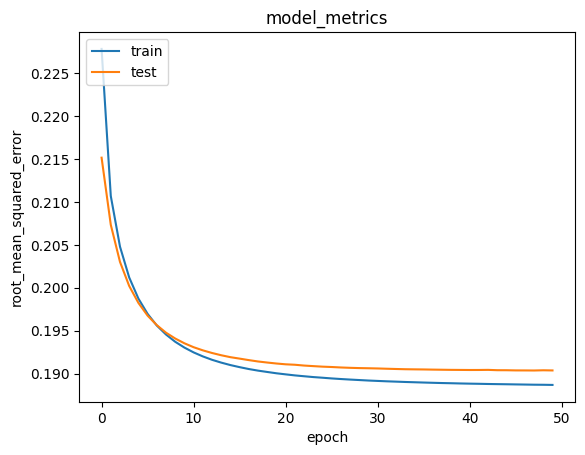

In [74]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Penurunan RMSE menunjukkan bahwa model secara progresif belajar untuk memprediksi rating dengan lebih akurat. Perbedaan yang minimal antara RMSE pelatihan dan validasi mengindikasikan bahwa model tidak mengalami overfitting yang signifikan dan mampu menggeneralisasi dengan baik pada data yang belum pernah dilihat sebelumnya. Nilai RMSE akhir (sekitar 0.32) relatif rendah dalam konteks skala rating 0-1, menunjukkan bahwa model memiliki kemampuan yang baik dalam memprediksi preferensi pengguna.

In [75]:
movie.head(10)

,movieId,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy
5,6,Heat (1995),action crime thriller
6,7,Sabrina (1995),comedy romance
7,8,Tom and Huck (1995),adventure children
8,9,Sudden Death (1995),action
9,10,GoldenEye (1995),action adventure thriller


In [76]:
rating_clean.head()

,userId,movieId,rating,user,movie
15347762,99476,104374,3.5,99475,3024
16647840,107979,2634,4.0,107978,9645
23915192,155372,1614,3.0,155371,1092
10052313,65225,7153,4.0,65224,227
12214125,79161,500,5.0,79160,964


#### Mekanisme Rekomendasi (Top-N Recommendation)

Setelah model terlatih, untuk pengguna tertentu, sistem mengidentifikasi film-film yang belum ditonton. Kemudian, model memprediksi rating untuk film-film tersebut. Film dengan prediksi rating tertinggi dipilih sebagai rekomendasi (Top-15, lalu diambil Top-10).

In [78]:
user_id = rating_clean.userId.sample(1).iloc[0]
movie_watched_by_user = rating_clean[rating_clean.userId == user_id]

movie_not_watched = movie[~movie['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId']
movie_not_watched = list(
    set(movie_not_watched).intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoded = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoded]]*len(movie_not_watched), movie_not_watched)
)

ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-15:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendation for users: {}'.format(user_id))
print('==='*9)
print('Movie with high ratings from user')
print('----'*8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending = False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie[movie['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)

print('----'*8)
print('Top 10 movie recommendations')
print('----'*8)

recommended_movie = movie[movie['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

1829/1829 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
Showing recommendation for users: 75595
Movie with high ratings from user
--------------------------------
Apollo 13 (1995) : adventure drama imax
Shawshank Redemption, The (1994) : crime drama
Eternal Sunshine of the Spotless Mind (2004) : drama romance sci-fi
Dark Knight, The (2008) : action crime drama imax
Inception (2010) : action crime drama mystery sci-fi thriller imax
--------------------------------
Top 10 movie recommendations
--------------------------------
Seven Samurai (Shichinin no samurai) (1954) : action adventure drama
High and Low (Tengoku to jigoku) (1963) : crime drama film-noir thriller
Harakiri (Seppuku) (1962) : drama
Century of the Self, The (2002) : documentary
Story of Film: An Odyssey, The (2011) : documentary
The Roosevelts: An Intimate History (2014) : documentary
It's Such a Beautiful Day (2011) : animation comedy drama
Planet Earth (2006) : documentary
Life (2009) : documentary
Over the Garden Wall (2013) : ad

Dari output diatas dapat diobservasi bahwasannya untuk user tersebut, sistem rekomendasi dapat memberikan rekomendasi yang sesuai dengan minat dari user, seperti misalnya user menyukai genre adventure, drama, dan imax pada urutan pertama seleranya, lalu kemudian direkomendasikan oleh model film-film dengan genre sejenis pada Top-10 rekomendasi, walaupun tidak sama persis namun secara garis besar genre dari film yang direkomendasikan masuk ke dalam selera dari user tersebut.

## Conclusion

Proyek ini telah berhasil mengimplementasikan dua pendekatan utama dalam sistem rekomendasi film, secara langsung menjawab pernyataan masalah yang diajukan.

1. **Implementasi Sistem Rekomendasi Film Berbasis Konten (Content-Based Filtering) telah berhasil dilakukan untuk secara efektif merekomendasikan film kepada pengguna berdasarkan preferensi mereka terhadap atribut film (genre).**

Melalui penggunaan TF-IDF Vectorizer untuk merepresentasikan genre film dan Cosine Similarity untuk mengukur kemiripan, sistem mampu mengidentifikasi dan merekomendasikan film-film yang memiliki karakteristik konten serupa dengan preferensi pengguna. Output rekomendasi menunjukkan konsistensi yang tinggi dalam hal genre dengan film input, membuktikan efektivitas pendekatan ini dalam menyediakan rekomendasi yang relevan secara kontekstual.


2. **Implementasi Sistem Rekomendasi Film Berbasis Kolaboratif (Collaborative Filtering) telah berhasil dilakukan untuk secara akurat memprediksi preferensi pengguna dan merekomendasikan film berdasarkan pola perilaku pengguna lain yang serupa.**

Dengan membangun dan melatih model Neural Network (RecommenderNet) menggunakan data rating pengguna, proyek ini menunjukkan kemampuan model untuk belajar pola preferensi yang kompleks. Penurunan signifikan pada metrik Root Mean Squared Error (RMSE) selama pelatihan mengindikasikan bahwa model dapat memprediksi rating film dengan akurasi yang baik. Hasil ini memungkinkan sistem untuk merekomendasikan film yang belum ditonton pengguna dengan potensi rating tertinggi, berdasarkan kesamaan perilaku dengan pengguna lain.

Secara keseluruhan, proyek ini berhasil menunjukkan kelayakan dan efektivitas implementasi kedua jenis sistem rekomendasi (content-based dan collaborative) pada dataset film, memberikan landasan yang kuat untuk pengembangan sistem rekomendasi yang lebih canggih di masa mendatang.